## Code and Documentation to Decode Popup Buoy Transmitted/Recorded Data

## Data Structure

Data downloaded from Popup Buoy's directly, generate 8 binary files.  A complete description of these files can be found at **[link]**.  Relevant pieces will be included in the notebook.

Filenames:
- BOTDAT.TXT
- FILEPOS.TXT
- ICEDAT.TXT
- JPGxxxxx.JPG
- PRODAT.TXT
- SSTDAT.TXT
- SUMMARY.TXT

In [1]:
instfile_dic = {'bot_file': 'sampledata/BOTDAT.TXT',
                'ice_file': 'sampledata/ICEDAT.TXT',
                'pro_file': 'sampledata/PRODAT.TXT',
                'sst_file': 'sampledata/SSTDAT.TXT'}

For each data file, we are going to read in the entire file and convert the binary to hex.  There are multiple line, lengths we are going to have to address but the start of each record is denoted by 'FFFF'.  We can split the filestring on this parameter but we need to be aware of 'FFFFF' or 'FFFFFF' posibilities

***Basic Approach***

The two modules below will allow for a simple readin of the file for very simple analysis and debugging... the code of consequence that involves conversion of measurements from engineering units to science units as all defined in the PopUpBuoy CLASS in the next section

In [2]:
def HexView(file):
    with open(file, 'rb') as in_file:
        while True:
            hexdata = in_file.read().hex().upper()     # Read the shortest possible line
            if len(hexdata) == 0:                      # breaks loop once no more binary data is read
                break
            
            return(hexdata.upper())
        
def HexSplit(hexstr):
    if hexstr.find('FFFFF') == -1:
        print("No FFFFF, proceed to split on FFFF")
        sample_raw = hexstr.split('FFFF')[1:]
    else:
        print('FFFFF found')
        #this puts in the proper line endings but removes a variable 
        #   F from the end of each string.  Add the F string back
        sample_raw = []
        for substr in hexstr.split('FFFFF')[1:]: 
            sample_raw = sample_raw + (substr + 'F').split('FFFF')

        sample_raw[-1] = sample_raw[-1][:-1]
        
    return(sample_raw)

In [3]:
active_file = instfile_dic['bot_file']

hexstr = HexView(active_file)
sample_raw = HexSplit(hexstr)


No FFFFF, proceed to split on FFFF


# Class description and routine code

## Decode sample data for each file type

### Bottom Data (BOTDAT.TXT) / Under Ice Data (ICEDAT.TXT)

This data has two record lengths.  17 and 19.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 17 (which is a string length of 30 and 34 characters)

***MSG Decode Key***
![BotDecodeMsg](decode_images/BotDat_msg_decode.png)

***Engineering to Science Conversions***
![BotDecodeMsg](decode_images/BotDat_msg_decode.png)


### Profile Data (PRODAT.TXT) /

This data has two record lengths.  13 and 15.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 11 and 13 (which is a string length of 30 and 34 characters).  This file does not have the bottom temp or the reference temp fields.


### Defining the PopUpBuoy Class

In [252]:
import numpy as np
import pandas as pd

class PopUpBuoys(object):
    """Class definitions to read and Process PopUp Buoy Data Streams"""

    ############################################################
    ### The following constants should be placed into a module
    #    so that they can be updated with a config file for each 
    sample_interval = {'bottom':3600,
                       'ice': 3600,
                       'profile': 0.25,
                       'sst': 3*3600} #seconds
    
    underside_temp_cal = { 'Acoef':0.00121376381803238,
                           'Bcoef':0.000522637158831552,
                           'Ccoef':1.41820495016536E-06 }

    topside_temp_cal = { 'Acoef':0.00121410745269167,
                         'Bcoef':0.000522254475008962,
                         'Ccoef':1.43969129191958E-06}
    
    par_cal = { 'offset': 5458,
                'slope': 0.01415} #offset and slope

    fluor_cal = { 'offset': 40,
                  'slope': 0.020920502} #offset and slope    
    ###########################################################
    active_stream = 'bottom'
    def __init__(self, path):
        self.path = path
        self.instfile_dic = {'bottom': path + '/BOTDAT.TXT',
                             'ice': path + '/ICEDAT.TXT',
                             'profile': path + '/PRODAT.TXT',
                             'sst': path + '/SSTDAT.TXT'}
    
    def LoadCoefs(self, coef_file):
        pass
    
    def HexView(self, sample='', verbose=True):
        '''
        input: reference to proper filepointer, options are keys to the self.instfile_dic dictionary
        '''
        if not sample:
            sample=self.active_stream
        else:
            self.active_stream = sample
            
        file = self.instfile_dic[sample]
        with open(file, 'rb') as in_file:
            while True:
                hexdata = in_file.read().hex().upper()     # Read the shortest possible line
                if len(hexdata) == 0:                      # breaks loop once no more binary data is read
                    break
                self.hexstr = hexdata.upper()
                
                if verbose:
                    return(hexdata.upper())

    def HexSplit(self, verbose=True):
        '''
        input: results of HexView (inherits output)
        '''
        if self.hexstr.find('FFFFF') == -1:
            print("No FFFFF, proceed to split on FFFF")
            sample_raw = self.hexstr.split('FFFF')[1:] #because in this case the first index is empty
        else:
            print('FFFFF found')
            #this puts in the proper line endings but removes a variable 
            #   F from the end of each string.  Add the F string back
            sample_raw = []
            for substr in self.hexstr.split('FFFFF'): 
                sample_raw = sample_raw + (substr + 'F').split('FFFF')

            #sample_raw[-1] = sample_raw[-1][:-1]
        
        self.sample_raw = sample_raw
        
        if verbose:
            return(sample_raw)
    
    def Bottom(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
        
        data={}

        for sample_num, sample in enumerate(self.sample_raw):
            
            if len(sample) == 30: #2byte timeword
                
                time = int(sample[0:4],16) * self.sample_interval['bottom'] #seconds since 1970-01-01
                
                pressure =  (int(sample[4:8],16) - 16384)* 10 / 32768  #bar
                
                rawtvalue = int(sample[8:12],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                topside_temp = 1 / ( self.topside_temp_cal['Acoef'] + 
                                     self.topside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                     self.topside_temp_cal['Ccoef']*np.log10(rawtvalue)**3 ) - 273.15
                                                                        #temp DegC

                rawtvalue = int(sample[12:16],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                underside_temp = 1 / ( self.underside_temp_cal['Acoef'] + 
                                       self.underside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                       self.underside_temp_cal['Ccoef']*np.log10(rawtvalue)**3 ) - 273.15                
                                                                        #temp DegC
                
                temp_ref = int(sample[16:20],16)                            #temp ref in ADC
                if temp_ref >= 0x8000:
                    temp_ref -= 0x10000                
                
                rawpvalue = int(sample[20:24],16)
                if rawpvalue >= 0x8000:
                    rawpvalue -= 0x10000                   
                
                par = (rawpvalue - self.par_cal['offset'])* self.par_cal['slope'] / 0.73 #PAR in umolm-2s-1
                
                rawfvalue = int(sample[24:28],16)
                if rawfvalue >= 0x8000:
                    rawfvalue -= 0x10000                   
                
                fluor = (rawfvalue - self.fluor_cal['offset'])* self.fluor_cal['slope']  #concentration in ug/L 
                
                tilt = int(sample[28:30],16) #degrees
                
            elif len(sample) == 34: #4byte timeword
                
                time = int(sample[0:8],16) * self.sample_interval['bottom'] #seconds since 1970-01-01
                
                pressure =  (int(sample[8:12],16) - 16384)* 10 / 32768  #bar
                
                rawtvalue = int(sample[12:16],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                topside_temp = 1 / ( self.topside_temp_cal['Acoef'] + 
                                     self.topside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                     self.topside_temp_cal['Ccoef']*np.log10(rawtvalue)**3 ) - 273.15
                                                                        #temp DegC

                rawtvalue = int(sample[16:20],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                underside_temp = 1 / ( self.underside_temp_cal['Acoef'] + 
                                       self.underside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                       self.underside_temp_cal['Ccoef']*np.log10(rawtvalue)**3 ) - 273.15                
                                                                        #temp DegC
                
                temp_ref = int(sample[20:24],16)                            #temp ref in ADC
                if temp_ref >= 0x8000:
                    temp_ref -= 0x10000                
                
                rawpvalue = int(sample[24:28],16)
                if rawpvalue >= 0x8000:
                    rawpvalue -= 0x10000                   
                
                par = (rawpvalue - self.par_cal['offset'])* self.par_cal['slope'] / 0.73 #PAR in umolm-2s-1
                
                rawfvalue = int(sample[28:32],16)
                if rawfvalue >= 0x8000:
                    rawfvalue -= 0x10000                   
                
                fluor = (rawfvalue - self.fluor_cal['offset'])* self.fluor_cal['slope']  #concentration in ug/L 
                
                tilt = int(sample[32:34],16) #degrees
                
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'underside_temp':underside_temp,
                                'temp_ref':temp_ref,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    
    def SST(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
        
        data={}

    def Profile(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
        
        data={}

        for sample_num, sample in enumerate(self.sample_raw):
                        
            if len(sample) == 22: #2byte timeword
                
                time = int(sample[0:4],16)/100 * self.sample_interval['profile'] + profile_starttime #seconds since 1970-01-01
                
                pressure =  (int(sample[4:8],16) - 16384)* 10 / 32768  #bar
                
                rawtvalue = int(sample[8:12],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                topside_temp = 1 / ( self.topside_temp_cal['Acoef'] + 
                                     self.topside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                     self.topside_temp_cal['Ccoef']*np.log10(rawtvalue)**3 ) - 273.15
                                                                        #temp DegC              
                
                rawpvalue = int(sample[12:16],16)
                if rawpvalue >= 0x8000:
                    rawpvalue -= 0x10000                   
                
                par = (rawpvalue - self.par_cal['offset'])* self.par_cal['slope'] / 0.73 #PAR in umolm-2s-1
                
                rawfvalue = int(sample[16:20],16)
                if rawfvalue >= 0x8000:
                    rawfvalue -= 0x10000                   
                
                fluor = (rawfvalue - self.fluor_cal['offset'])* self.fluor_cal['slope']  #concentration in ug/L 
                
                tilt = int(sample[20:22],16) #degrees
                
            elif len(sample) == 26: #4byte timeword, reserved for profile starttime
                
                profile_starttime = int(sample[0:8],16) #seconds since 1970-01-01
                time = profile_starttime
                
                pressure =  (int(sample[8:12],16) - 16384)* 10 / 32768  #bar
                
                rawtvalue = int(sample[12:16],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                topside_temp = 1 / ( self.topside_temp_cal['Acoef'] + 
                                     self.topside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                     self.topside_temp_cal['Ccoef']*np.log10(rawtvalue)**3 ) - 273.15
                                                                        #temp DegC
              
                
                rawpvalue = int(sample[16:20],16)
                if rawpvalue >= 0x8000:
                    rawpvalue -= 0x10000                   
                
                par = (rawpvalue - self.par_cal['offset'])* self.par_cal['slope'] / 0.73 #PAR in umolm-2s-1
                
                rawfvalue = int(sample[20:24],16)
                if rawfvalue >= 0x8000:
                    rawfvalue -= 0x10000                   
                
                fluor = (rawfvalue - self.fluor_cal['offset'])* self.fluor_cal['slope']  #concentration in ug/L 
                
                tilt = int(sample[24:26],16) #degrees
            
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
        
    def Ice(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
        
        data={}

        for sample_num, sample in enumerate(self.sample_raw):
            
            if len(sample) == 30: #2byte timeword
                
                time = int(sample[0:4],16) * self.sample_interval['ice'] #seconds since 1970-01-01
                
                pressure =  (int(sample[4:8],16) - 16384)* 10 / 32768  #bar
                
                rawtvalue = int(sample[8:12],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                topside_temp = 1 / ( self.topside_temp_cal['Acoef'] + 
                                     self.topside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                     self.topside_temp_cal['Ccoef']*np.log10(rawtvalue)**3 ) - 273.15
                                                                        #temp DegC

                rawtvalue = int(sample[12:16],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                underside_temp = 1 / ( self.underside_temp_cal['Acoef'] + 
                                       self.underside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                       self.underside_temp_cal['Ccoef']*np.log10(rawtvalue)**3 ) - 273.15                
                                                                        #temp DegC
                
                temp_ref = int(sample[16:20],16)                            #temp ref in ADC
                if temp_ref >= 0x8000:
                    temp_ref -= 0x10000                
                
                rawpvalue = int(sample[20:24],16)
                if rawpvalue >= 0x8000:
                    rawpvalue -= 0x10000                   
                
                par = (rawpvalue - self.par_cal['offset'])* self.par_cal['slope'] / 0.73 #PAR in umolm-2s-1
                
                rawfvalue = int(sample[24:28],16)
                if rawfvalue >= 0x8000:
                    rawfvalue -= 0x10000                   
                
                fluor = (rawfvalue - self.fluor_cal['offset'])* self.fluor_cal['slope']  #concentration in ug/L 
                
                tilt = int(sample[28:30],16) #degrees
                
            elif len(sample) == 34: #4byte timeword
                
                time = int(sample[0:8],16) * self.sample_interval['ice'] #seconds since 1970-01-01
                
                pressure =  (int(sample[8:12],16) - 16384)* 10 / 32768  #bar
                
                rawtvalue = int(sample[12:16],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                topside_temp = 1 / ( self.topside_temp_cal['Acoef'] + 
                                     self.topside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                     self.topside_temp_cal['Ccoef']*np.log10(rawtvalue)**3. ) - 273.15
                                                                        #temp DegC

                rawtvalue = int(sample[16:20],16)
                if rawtvalue >= 0x8000:
                    rawtvalue -= 0x10000
                underside_temp = 1 / ( self.underside_temp_cal['Acoef'] + 
                                       self.underside_temp_cal['Bcoef']*np.log10(rawtvalue) + 
                                       self.underside_temp_cal['Ccoef']*np.log10(rawtvalue)**3. ) - 273.15                
                                                                        #temp DegC
                
                temp_ref = int(sample[20:24],16)                            #temp ref in ADC
                if temp_ref >= 0x8000:
                    temp_ref -= 0x10000                
                
                rawpvalue = int(sample[24:28],16)
                if rawpvalue >= 0x8000:
                    rawpvalue -= 0x10000                   
                
                par = (rawpvalue - self.par_cal['offset'])* self.par_cal['slope'] / 0.73 #PAR in umolm-2s-1
                
                rawfvalue = int(sample[28:32],16)
                if rawfvalue >= 0x8000:
                    rawfvalue -= 0x10000                   
                
                fluor = (rawfvalue - self.fluor_cal['offset'])* self.fluor_cal['slope']  #concentration in ug/L 
                
                tilt = int(sample[32:34],16) #degrees
                
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'underside_temp':underside_temp,
                                'temp_ref':temp_ref,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)

## Sample Evaluation of routine

Imagine a buoy with ID number 119087.  Instantiate a PopUpBuoys class with the relative (or absolute) path to the location of the download/reconstructed data files

In [253]:
ID119087 = PopUpBuoys('sampledata')

Call the routine to read and convert the binary file to a hex string... the sample parameter is the name of the data type.

sample options are:
+ bottom
+ sst
+ profile
+ ice

passing 'verbose=True' returns the hex string

In [254]:
ID119087.HexView(sample='bottom',verbose=True)

'FFFF000049BE298E2960214E1D30005907FFFF000149C0296C2944214F1A2C004A07FFFF000249C029502933214F18AC003D07FFFF000349C229452931214F17A0003D07FFFF000449C3294A293B214F15F0004507FFFF000549C429542949214F1558004307FFFF000649C629612957214F1552004207FFFF000749C529682962214F1552003407FFFF000849C72975296F214F1552003707FFFF000949C929842980214F1552003607FFFF000A49C92993298F214F1552002F07FFFF000B49CA29A329A0214F1552004C07FFFF000C49CA29B329B0214F1552003D07FFFF000D49CA29BE29BD214F1552003807FFFF000E49CB29CC29CB214F1552002E07FFFF000F49CC29D729D5214F1552003E07FFFF001049CD29E329E2214F15C0003A07'

In [255]:
ID119087.HexSplit(verbose=True)

No FFFFF, proceed to split on FFFF


['000049BE298E2960214E1D30005907',
 '000149C0296C2944214F1A2C004A07',
 '000249C029502933214F18AC003D07',
 '000349C229452931214F17A0003D07',
 '000449C3294A293B214F15F0004507',
 '000549C429542949214F1558004307',
 '000649C629612957214F1552004207',
 '000749C529682962214F1552003407',
 '000849C72975296F214F1552003707',
 '000949C929842980214F1552003607',
 '000A49C92993298F214F1552002F07',
 '000B49CA29A329A0214F1552004C07',
 '000C49CA29B329B0214F1552003D07',
 '000D49CA29BE29BD214F1552003807',
 '000E49CB29CC29CB214F1552002E07',
 '000F49CC29D729D5214F1552003E07',
 '001049CD29E329E2214F15C0003A07']

In [256]:
bottom_data = ID119087.Bottom(asPandas=True)

In [257]:
bottom_data

,time,pressure,topside_temp,underside_temp,temp_ref,par,fluor,tilt
0,0,0.761108,20.005236,20.118637,8526,39.038493,1.025105,7
1,3600,0.761719,20.076017,20.177135,8527,24.074384,0.711297,7
2,7200,0.761719,20.134499,20.212737,8527,16.631096,0.439331,7
3,10800,0.762329,20.157521,20.216930,8527,11.436301,0.439331,7
4,14400,0.762634,20.147053,20.195975,8527,3.062603,0.606695,7
5,18000,0.762939,20.126133,20.166676,8527,0.116301,0.564854,7
6,21600,0.763550,20.098971,20.137421,8527,0.000000,0.543933,7
7,25200,0.763245,20.084360,20.114465,8527,0.000000,0.251046,7
8,28800,0.763855,20.057256,20.087370,8527,0.000000,0.313808,7
9,32400,0.764465,20.026027,20.051994,8527,0.000000,0.292887,7


In [258]:
ID119087.HexView(sample='ice',verbose=False)
ID119087.HexSplit(verbose=False)
ice_data = ID119087.Ice(asPandas=True)

No FFFFF, proceed to split on FFFF


In [259]:
ice_data

,time,pressure,topside_temp,underside_temp,temp_ref,par,fluor,tilt
0,10800,0.038147,20.144960,20.060312,8527,328.609521,0.857741,13
1,14400,0.037842,20.273042,20.152043,8527,451.036096,0.376569,14
2,18000,0.037842,20.621583,20.223221,8527,500.677397,0.732218,14
3,21600,0.037231,20.279362,20.269415,8527,187.419658,0.690377,13
4,25200,0.037231,20.315218,20.284136,8527,98.972466,0.753138,13
5,28800,0.037231,20.346909,20.330473,8527,53.653699,0.313808,13
6,32400,0.037231,20.298336,20.322040,8527,27.718493,0.606695,14
7,36000,0.037231,20.296227,20.311504,8527,1.046712,0.334728,14
8,39600,0.037842,20.273042,20.298868,8527,0.000000,0.292887,13
9,43200,0.037842,20.277255,20.290448,8527,0.000000,0.543933,14


In [260]:
hv = ID119087.HexView(sample='profile',verbose=True)
hs = ID119087.HexSplit(verbose=True)
pro_data = ID119087.Profile(asPandas=True)

FFFFF found


In [265]:
hs

['',
 '5B87A40049CE29EA29E9214F17E8004507',
 '5B87B89D467929ED19EC004104',
 '0000467729ED19EC004104',
 '0019466529ED1A21004815',
 '0032465529ED1A4F005415',
 '004B464C29ED1A61004613',
 '0064464329ED1A63004A0C',
 '007D462D29ED1A6B004B0A',
 '0096460529ED1A9300390C',
 '00AF45E029ED1ADC003B11',
 '00C845C629ED1B03004510',
 '00E145BD29ED1B0B002F0B',
 '00FA45BE29ED1B00003805',
 '011345B929ED1B0C004609',
 '012C45AD29EE1B3A004011',
 '0145459529EE1B67004216',
 '015E457729EE1BAA004816',
 '0177456129EE1BAB003D0D',
 '0190454929EE1BA4004007',
 '01A9452C29EE1BB7003507',
 '01C2451129EE1BCF00310B',
 '01DB450729EE1C0000300B',
 '01F4451329EE1C0300310E',
 '020D451C29EE1C0C00390E',
 '0226451929EE1BFD003B11',
 '023F450129EE1C16003715',
 '025844E929EE1C31003911',
 '027144D529EF1C3000420F',
 '028A44CA29EE1C33003507',
 '02A344C529EF1C45003408',
 '02BC44C229EF1C7000300B',
 '02D544B529EF1C9C003513',
 '02EE44A429EF1CE8002E15',
 '0307448729EF1D1B003A14',
 '0320446D29EF1D35004D0E',
 '0339446229EF1D14003B05',
 '03524

In [261]:
pro_data

,time,pressure,topside_temp,par,fluor,tilt
2,1.535621e+09,0.505676,19.808807,22.833836,0.523013,4
3,1.535621e+09,0.505066,19.808807,22.833836,0.523013,4
4,1.535621e+09,0.499573,19.808807,23.861164,0.669456,21
5,1.535621e+09,0.494690,19.808807,24.752808,0.920502,21
6,1.535621e+09,0.491943,19.808807,25.101712,0.627615,19
7,1.535621e+09,0.489197,19.808807,25.140479,0.711297,12
8,1.535621e+09,0.482483,19.808807,25.295548,0.732218,10
9,1.535621e+09,0.470276,19.808807,26.070890,0.355649,12
10,1.535621e+09,0.458984,19.808807,27.485890,0.397490,17
11,1.535621e+09,0.451050,19.808807,28.241849,0.606695,16


## Plotting Fun

Since a pandas dataframe is a native output, quicklook plots are very easy to obtain as are output to csv for other software

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120502be0>,
      dtype=object)

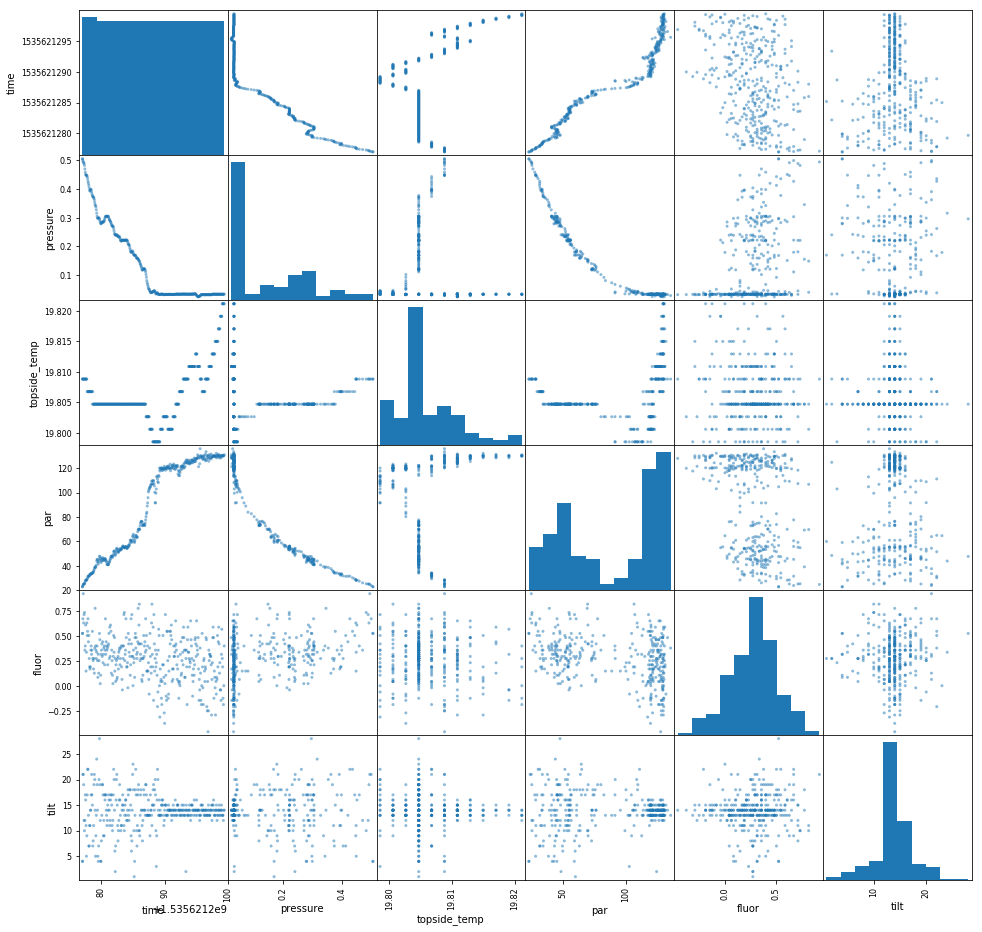

In [262]:
%matplotlib inline
pd.plotting.scatter_matrix(pro_data, figsize=(16, 16))

### Convert elapse time to datetime

In [263]:
from netCDF4 import num2date
pro_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in pro_data.iterrows()]

In [264]:
pro_data['datetime']

2     2018-08-30 09:27:57.000000
3     2018-08-30 09:27:57.000000
4     2018-08-30 09:27:57.062500
5     2018-08-30 09:27:57.125000
6     2018-08-30 09:27:57.187500
7     2018-08-30 09:27:57.250000
8     2018-08-30 09:27:57.312500
9     2018-08-30 09:27:57.375000
10    2018-08-30 09:27:57.437500
11    2018-08-30 09:27:57.500000
12    2018-08-30 09:27:57.562500
13    2018-08-30 09:27:57.625000
14    2018-08-30 09:27:57.687500
15    2018-08-30 09:27:57.750000
16    2018-08-30 09:27:57.812500
17    2018-08-30 09:27:57.875000
18    2018-08-30 09:27:57.937500
19    2018-08-30 09:27:58.000000
20    2018-08-30 09:27:58.062500
21    2018-08-30 09:27:58.125000
22    2018-08-30 09:27:58.187500
23    2018-08-30 09:27:58.250000
24    2018-08-30 09:27:58.312500
25    2018-08-30 09:27:58.375000
26    2018-08-30 09:27:58.437500
27    2018-08-30 09:27:58.500000
28    2018-08-30 09:27:58.562500
29    2018-08-30 09:27:58.625000
30    2018-08-30 09:27:58.687500
31    2018-08-30 09:27:58.750000
          